from csmarapi.CsmarService import CsmarService
csmar = CsmarService()
from csmarapi.ReportUtil import ReportUtil

csmar.login()

In [1]:
import re
from functools import reduce
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dask import dataframe as ddf

# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def round_(data : float):
    return str(round(data, 4)*100) + '%'

In [3]:
%%time

maininfo = pd.read_csv('data/FUND_MainInfo.csv', parse_dates=['InceptionDate'])
maininfo['InceptionDate'] = maininfo.InceptionDate.dt.to_period('M')


unitclassinfo = pd.read_csv('data/FUND_UnitClassInfo.csv', parse_dates=['ListingDate', 'InceptionDate'])
unitclassinfo['InceptionDate'] = unitclassinfo.InceptionDate.dt.to_period('M')
unitclassinfo['MasterFundCode'] = unitclassinfo.MasterFundCode.astype('Int64')


allocation = pd.read_csv('data/Fund_Allocation.csv', parse_dates=['Startdate', 'EndDate'])
allocation['Startdate'] = allocation.Startdate.dt.to_period('M')
allocation['EndDate'] = allocation.EndDate.dt.to_period('M')


fees = ddf.read_csv('data/管理费率/*', dtype={'Symbol': 'object', 'ProportionOfFee': 'object'}, parse_dates=['DeclareDate']).compute()
fees['DeclareDate'] = fees.DeclareDate.dt.to_period('M')
fees['Symbol'] = fees.Symbol.astype(int)


fund_dividend = pd.read_csv('data/Fund_FundDividend.csv', parse_dates=['PrimaryExDividendDate', 'SecondaryExDividendDate'])
fund_dividend['PrimaryExDividendDate'] = fund_dividend.PrimaryExDividendDate.dt.to_period('M')


nav_month = pd.read_csv('data/Fund_NAV_Month.csv', parse_dates=['TradingDate'])
nav_month['TradingDate'] = nav_month.TradingDate.dt.to_period('M')


resolution = pd.read_csv('data/Fund_Resolution.csv', parse_dates=['DeclareDate'])
resolution['DeclareDate'] = resolution.DeclareDate.dt.to_period('M')


mkt_month = pd.read_csv('data/Fund_MKT_QuotationMonth.csv', parse_dates=['TradingDate'])
mkt_month['TradingDate'] = mkt_month.TradingDate.dt.to_period('M')


share_info = pd.read_csv('data/Fund_ShareChange.csv', parse_dates=['EndDate'])
share_info['EndDate'] = share_info.EndDate.dt.to_period('M')


CPU times: total: 2.14 s
Wall time: 2.36 s


### #data-insight/EDA

 #**1. `Symbol`, `MasterFundCode`, `FundID`?**

`Symbol` is queryable in Win.d

`Symbol` translates as  `前端代码(Win.d)/基金代码(CSMAR)/前端代码(CSMAR)`

`Symbol == 11228` means `011228.OF`

`Symbol` is not available in `FUND_MainInfo 基金概况 — 基金主体信息表`, `Fund_Allocation 基金投组 — 资产配置文件`

`Symbol` may map more than one fund name, only the latest one is ongoing, **use the latest one** (checked `Win.d`)

`MasterFundCode` is the first `Symbol` in ***a collection of funds***

***a collection of funds, e.g.***

*西部利得量化成长A, 000006.OF, 2019-03-19*

*西部利得量化成长C, 011228.OF, 2021-01-13*

*or*

*中海可转债A, 000003.OF, 2013-03-20*

*中海可转债C, 000004.OF, 2013-03-20*

|            |                    | A      | C       |                          |
| ---------- | ------------------ | ------ | ------- | ------------------------ |
| 运作方式   | operation          | same   | same    |                          |
| 管理费     | management fee     | same   | same    |                          |
| 认购费     | purchase fee       | √     |         |                          |
| 销售服务费 | sales service fees |        | √      | charge from net value |
| 赎回费     | redemption fee    | bigger | smaller |                          |

*≈60%* `MasterFundCode` has multiple symbols

`MasterFundCode` can be inferred from `Symbol`

`FundID` is in bijection with `MasterFundCode`

`FundID` is not queryable in Win.d --> *`FundID` used by CSMAR only?*

`Symbol` is not available in `FUND_MainInfo 基金概况 — 基金主体信息表`, `Fund_Allocation 基金投组 — 资产配置文件`

**use `Symbol`**

 #**2. `InceptionDate`, `ListingDate`?**
 
`InceptionDate`: 成立日期

`ListingDate`: 上市日期

*<10%* `ListingDate` is available

*=100%* `InceptionDate` is available

*≈85%* collection of funds has the same `InceptionDate`

**use `InceptionDate`**

 #**3. `Equity`, `StockAmount`? `allocation` data quality**

`Equity` is ≈60% the same as `StockAmount`

when `StockAmount` is not available, ≈100% `Equity` is available

when `Equity` is not available, ≈0% `StockAmount` is available

**use `Equity`**

but, ≈30% `Equity` is not available while `TotalAsset` is available

固定收益类投资

in the last report period, ≈30% `Equity` is not available while `TotalAsset` is available

 #**4. `unitclassinfo`, `nav_month`**

检查0

wrong data, in `nav_month`, ≈1.5% values are 0

**`nav_month`, `unitclassinfo` both have unique symbols in itself**

 #**5. `Fund_Resolution`, `Fund_FundDividend`**

≈1% fund have multiple dividend payouts in one month, `sum` them

≈1% fund have multiple divisions in one month, `cumulative product` them

 #**6. `Fund_FeesChange`**

≈0.01% data are duplicated

compared with `Win.d`, **we should keep the first one**

## I. Data Preprocessing

### 1. align MasterFundCode, Symbol

#### i. check: FUND_MainInfo

基金概况 — 基金主体信息表

<span style="color: red">`Symbol`/`FrontendCode` not available</span> 

In [4]:
specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=2, cols=2, specs=specs)
fig.add_trace(go.Pie(labels=maininfo.Category.value_counts().index, values=maininfo.Category.value_counts().values), 1, 1)

# IsETF [是否ETF] - 1=是；2=否
fig.add_trace(go.Pie(labels=maininfo.replace([1, 2], ['ETF', '非ETF'])\
    .IsETF.value_counts().index, values=maininfo.IsETF.value_counts().values), 1, 2)

# IsQDII [是否QDII] - 1=是；2=否
fig.add_trace(go.Pie(labels=maininfo.replace([1, 2], ['QDII', '非QDII'])\
    .IsQDII.value_counts().index, values=maininfo.IsQDII.value_counts().values), 2, 1)
    
# IsActiveOrPassive [主动标识] - 1=主动；2=被动
fig.add_trace(go.Pie(labels=maininfo.replace([1, 2, np.nan], ['1主动', '2被动', '空'])\
    .IsActiveOrPassive.value_counts().index, values=maininfo.replace([1, 2, np.nan], ['1主动', '2被动', '空']).IsActiveOrPassive.value_counts().values), 2, 2)
fig.update_layout(width=800, height=800)


In [5]:
(maininfo.groupby('MasterFundCode').apply(lambda per_MasterFundCode: len(per_MasterFundCode.FundID.unique())) != 1).any()

False

In [6]:
(maininfo.groupby('FundID').apply(lambda per_FundID: len(per_FundID.MasterFundCode.unique())) != 1).any()

False

`FundID` is in bijection with `MasterFundCode`, they make no difference in later research

Use `MasterFundCode` instead of `FundID`, because `MasterFundCode` is covered in most tables


#### ii. check: FUND_UnitClassInfo

基金概况 — 基金份额类别信息表

**erratum**

*problem*: use `Symbol` to merge `maininfo`, found ≈3% duplicated `Symbol`

*reason*: fund changed its name

*solve*: keep the latest `Symbol`

In [124]:
nav_month

,TradingDate,TradingMonth,Symbol,NAV
0,2002-01,2002-01,1,1.0020
1,2002-02,2002-02,1,1.0130
2,2002-03,2002-03,1,1.0230
3,2002-04,2002-04,1,1.0460
4,2002-05,2002-05,1,1.0270
...,...,...,...,...
868704,2022-04,2022-04,980003,1.5306
868705,2022-05,2022-05,980003,1.5365
868706,2022-06,2022-06,980003,1.5393
868707,2022-07,2022-07,980003,1.5449


In [7]:
unitclassinfo[unitclassinfo.Symbol.duplicated(keep=False)]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
28,37,37,广发理财7天债券A,2013-06,NaT
29,37,37,广发景宁纯债A,2020-04,NaT
85,104,104,华宸未来信用增利,2013-08,NaT
86,104,104,华宸未来稳健添利债券A,2018-08,NaT
114,134,134,理财28日盈A,2017-05,NaT
...,...,...,...,...,...
18661,660016,660016,农银汇理金聚高等级债券,2020-06,NaT
18680,673100,673100,西部利得久安回报混合,2017-03,NaT
18681,673100,673100,西部利得沪深300指数增强A,2018-12,NaT
18729,690012,690012,民生加银家盈理财7天债券A,2013-02,NaT


<img src="attachment/37_.png" alt="drawing" width="200"/> <img src="attachment/37.jpg" alt="drawing" width="800"/>
<img src="attachment/104_.png" alt="drawing" width="200"/> <img src="attachment/104.png" alt="drawing" width="800"/>

In [8]:
round_(len(unitclassinfo[unitclassinfo.Symbol.duplicated(keep=False)]) / len(unitclassinfo)) + ' funds changed name'

'2.5100000000000002% funds changed name'

In [9]:
unitclassinfo_ = unitclassinfo.drop_duplicates(subset=['Symbol'], keep='last')

**erratum**

*problem*: ≈0.5% *NA* `MasterFundCode`

*reason*: wrong data

*method*: delete all *NA* `MasterFundCode`

In [10]:
unitclassinfo_[pd.isnull(unitclassinfo_.MasterFundCode)]
# `unitclassinfo_.MasterFundCode` is `Int64`, display <NA> instead of NaN

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
927,<NA>,1041,南方理财60天债券E,2015-03,NaT
1715,<NA>,1888,中欧盛世成长混合(LOF)E,2015-10,NaT
2104,<NA>,2294,博时新机遇混合C,2016-01,NaT
2221,<NA>,2418,汇添富优选回报混合C,2016-02,NaT
2387,<NA>,2591,中欧信用增利债券E,2016-04,NaT
...,...,...,...,...,...
16589,<NA>,163008,长信利鑫债券(LOF)A,2017-01,NaT
16705,<NA>,164822,工银政府债纯债债券C,2017-01,NaT
16828,<NA>,167502,宝利A,2013-07,NaT
16966,<NA>,202308,南方收益宝货币B,2015-07,NaT


<img src="attachment/1041.png" alt="drawing" width="400"/> <img src="attachment/1041_.png" alt="drawing" width="400"/>

<img src="attachment/1888.png" alt="drawing" width="400"/> <img src="attachment/1888_.png" alt="drawing" width="400"/>

In [11]:
unitclassinfo_[unitclassinfo_.Symbol == 1041]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
927,<NA>,1041,南方理财60天债券E,2015-03,NaT


In [12]:
unitclassinfo_[unitclassinfo_.Symbol == 1888]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
1715,<NA>,1888,中欧盛世成长混合(LOF)E,2015-10,NaT


In [13]:
round_(pd.isnull(unitclassinfo_.MasterFundCode).sum() / len(unitclassinfo)) + ' error'

'0.53% error'

In [14]:
unitclassinfo_ = unitclassinfo_[pd.notnull(unitclassinfo_.MasterFundCode)]
unitclassinfo__ = unitclassinfo_.set_index(['MasterFundCode', 'Symbol'])
unitclassinfo__

ShortName InceptionDate ListingDate
MasterFundCode Symbol                                            
3              3                 中海可转债A       2013-03         NaT
               4                 中海可转债C       2013-03         NaT
5              5             嘉实增强信用定期债券       2013-03         NaT
6              6            西部利得量化成长混合A       2019-03         NaT
7              7                鹏华国企债债券       2013-03         NaT
...                                 ...           ...         ...
970191         970191         申万宏源天天增货币       2022-08         NaT
920187         970193    中金丰裕稳健一年持有混合型C       2022-07         NaT
970194         970194  兴证资管金麒麟3个月(FOF)A       2022-09         NaT
               970195  兴证资管金麒麟3个月(FOF)C       2022-09         NaT
980003         980003    太平洋证券六个月滚动持有债券       2020-04         NaT

[18915 rows x 3 columns]

In [15]:
f'{round_(pd.notnull(unitclassinfo__.ListingDate).sum() / len(unitclassinfo__))} of `ListingDate` available'

'8.61% of `ListingDate` available'

In [16]:
f'{round_(pd.notnull(unitclassinfo__.InceptionDate).sum() / len(unitclassinfo__))} of `InceptionDate` available'

'100.0% of `InceptionDate` available'

In [17]:
f'{round_(len(unitclassinfo__.index.levels[0]) / len(unitclassinfo__.index.levels[1]))} `MasterFundCode` have multiple symbols'

'60.150000000000006% `MasterFundCode` have multiple symbols'

In [18]:
symbol_date_identical = unitclassinfo__.groupby(level=0).apply(lambda _: True if len(_.InceptionDate.unique()) == 1 else False)
f'{round_(symbol_date_identical.sum() / len(symbol_date_identical))} `MasterFundCode` which have multiple symbols, have identical `InceptionDate`'

'85.39999999999999% `MasterFundCode` which have multiple symbols, have identical `InceptionDate`'

**erratum**

*problem*: ≈0.22% `unitclassinfo` has less unique `MasterFundCode`, while `maininfo` has all `MasterFundCode`

*reason*:

- fund changed its name

- lack of data

*method*: use `MasterFundCode` & `Symbol` in `unitclassinfo`

In [19]:
np.setdiff1d(unitclassinfo_.MasterFundCode, maininfo.MasterFundCode.unique())

array([], dtype=int32)

In [20]:
np.setdiff1d(maininfo.MasterFundCode.unique(), unitclassinfo_.MasterFundCode)

array([   500,    622,    791,    813,    909,  10656,  12570,  13363,
        15393,  15514,  15838,  15948,  16005,  16250,  16396,  16454,
        16513,  16517,  16566,  16596,  16609, 180102, 240021, 550017,
       970186], dtype=int64)

In [42]:
# e.g. fund changed its name
maininfo[maininfo.MasterFundCode == 500]

,FundID,MasterFundCode,FullName,InceptionDate,Category,IsETF,IsQDII,IsActiveOrPassive
293,10131316,500,华富恒富分级债券型证券投资基金,2014-03,债券型基金,2,2,NaN


In [25]:
# e.g. fund changed its name
# locate `MasterFundCode == 500`, find `Symbol == 501` or `Symbol == 502`
unitclassinfo[unitclassinfo.MasterFundCode == 500]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
425,500,501,华富恒富分级债券A,2014-03,NaT
427,500,502,华富恒富分级债券B,2014-03,NaT


In [31]:
# e.g. fund changed its name
# `Symbol == 501` or `Symbol == 502` in original data
# the latest `MasterFundCode` change to 502, instead of 500
# but they have same `Symbol`
unitclassinfo[unitclassinfo.Symbol == 501]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
425,500,501,华富恒富分级债券A,2014-03,NaT
426,502,501,华富恒富18个月定开债C,2017-11,NaT


In [36]:
# e.g. fund changed its name
unitclassinfo_[unitclassinfo_.Symbol == 501]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
426,502,501,华富恒富18个月定开债C,2017-11,NaT


In [37]:
# e.g. fund changed its name
unitclassinfo[unitclassinfo.Symbol == 502]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
427,500,502,华富恒富分级债券B,2014-03,NaT
428,502,502,华富恒富18个月定开债A,2017-11,NaT


In [40]:
# e.g. fund changed its name
unitclassinfo_[unitclassinfo_.Symbol == 502]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate
428,502,502,华富恒富18个月定开债A,2017-11,NaT


In [38]:
# e.g. fund changed its name
unitclassinfo_[unitclassinfo_.MasterFundCode == 500]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate


In [51]:
# 500, 622, 791, 813, 909 are due to renaming

# e.g. lack of data
unitclassinfo[unitclassinfo.MasterFundCode == 10656]

,MasterFundCode,Symbol,ShortName,InceptionDate,ListingDate


In [52]:
# `MasterFundCode` included in `maininfo` but not in `unitclassinfo`
# some born NA, some changed name

f'{round_(len(np.setdiff1d(maininfo.MasterFundCode.unique(), unitclassinfo_.MasterFundCode)) / len(maininfo.MasterFundCode.unique()))} \
MasterFundCode will be dropped'

'0.22% MasterFundCode will be dropped'

#### iii. concatenate

**Q**: We use `Symbol`, and `Symbol` is duplicated, why drop `MasterFundCode` here?

**A**: `MasterFundCode` is the proper `key` both table have in common. If we drop with `key` of `Symbol`, program does not know what to do with `maininfo`

In [53]:
selected_columns = ['FundID', 'MasterFundCode', 'FullName', 'Symbol', 'InceptionDate_y', 'Category', 'IsETF', 'IsQDII', 'IsActiveOrPassive']
maininfo_ = pd.merge(maininfo, unitclassinfo_, how='inner' ,on='MasterFundCode')[selected_columns].drop_duplicates(subset='Symbol').reset_index(drop=True)
maininfo_

,FundID,MasterFundCode,FullName,Symbol,InceptionDate_y,Category,IsETF,IsQDII,IsActiveOrPassive
0,10110606,3,中海可转换债券债券型证券投资基金,3,2013-03,债券型基金,2,2,NaN
1,10110606,3,中海可转换债券债券型证券投资基金,4,2013-03,债券型基金,2,2,NaN
2,10110338,5,嘉实增强信用定期开放债券型证券投资基金,5,2013-03,债券型基金,2,2,NaN
3,10445836,6,西部利得量化成长混合型发起式证券投资基金,6,2019-03,混合型基金,2,2,1.0
4,10445836,6,西部利得量化成长混合型发起式证券投资基金,11228,2021-01,混合型基金,2,2,1.0
...,...,...,...,...,...,...,...,...,...
18910,10596615,970187,申万宏源天添利货币型集合资产管理计划,970187,2022-08,货币型基金,2,2,NaN
18911,10596605,970191,申万宏源天天增货币型集合资产管理计划,970191,2022-08,货币型基金,2,2,NaN
18912,10598181,970194,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,970194,2022-09,FOF,2,2,1.0
18913,10598181,970194,兴证资管金麒麟3个月持有期混合型基金中基金(FOF)集合资产管理计划,970195,2022-09,FOF,2,2,1.0


### 2. filter data

#### i. first 4 : static filtering

（1）基金类别必须为“股票型基金”或“混合型基金”；

（2）非 ETF 类基金；

（3）非 QDII 类基金；

（4）主动管理标识为 1 或者为空；

In [54]:
filter_1 = np.logical_or(maininfo_.Category == '股票型基金', maininfo_.Category == '混合型基金')
filter_2 = maininfo_.IsETF == 2
filter_3 = maininfo_.IsQDII == 2
filter_4 = maininfo_.IsActiveOrPassive != 2

filters = [(1, filter_1), (2, filter_2), (3, filter_3), (4, filter_4)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(maininfo_)

# proportional data left

array([0.61908538, 0.9554322 , 0.97383029, 0.83246101])

In [55]:
def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(maininfo_)} to {previous[1].sum()}, ' + round_(1 - previous[1].sum() / len(maininfo_)) + ' symbols dropped')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}, ' + round_(1 - temp.sum() / previous[1].sum()) + ' symbols dropped')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}, ' + round_(1 - temp.sum() / previous.sum()) + ' symbols dropped')
        return temp


filters_ = reduce(func, filters)

filter 1: 18915 to 11710, 38.09% symbols dropped
filter 2: 11710 to 10969, 6.329999999999999% symbols dropped
filter 3: 10969 to 10654, 2.87% symbols dropped
filter 4: 10654 to 8786, 17.53% symbols dropped


In [89]:
maininfo__ = maininfo_[filters_]
maininfo__.set_index('Symbol').sort_index()

,FundID,MasterFundCode,FullName,InceptionDate_y,Category,IsETF,IsQDII,IsActiveOrPassive
Symbol,,,,,,,,
6,10445836,6,西部利得量化成长混合型发起式证券投资基金,2019-03,混合型基金,2,2,1.0
11,107794,11,华夏大盘精选证券投资基金,2004-08,混合型基金,2,2,1.0
17,10110640,17,财通可持续发展主题混合型证券投资基金,2013-03,混合型基金,2,2,1.0
20,10110534,20,景顺长城品质投资混合型证券投资基金,2013-03,混合型基金,2,2,1.0
21,10102822,21,华夏优势增长混合型证券投资基金,2006-11,混合型基金,2,2,1.0
...,...,...,...,...,...,...,...,...
970120,10578152,970120,兴证资管金麒麟恒睿致远一年持有期混合型集合资产管理计划,2021-12,混合型基金,2,2,1.0
970121,10578152,970120,兴证资管金麒麟恒睿致远一年持有期混合型集合资产管理计划,2021-12,混合型基金,2,2,1.0
970184,10596614,880006,招商资管核心优势混合型集合资产管理计划,2022-08,混合型基金,2,2,1.0


#### ii. use filtered data (first 4) to create big table

big table: from `Symbol` indexed only to `Symbol-Month` multiIndex

In [125]:
indexes = pd.MultiIndex.from_product([maininfo__.Symbol.sort_values().values, pd.date_range('2002-1', '2022-10', freq='Q')])
temp_symbols = indexes.get_level_values(0)
temp_EndDate = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['Symbol'] = temp_symbols
main_data['EndDate'] = temp_EndDate.to_period('M')
main_data = pd.merge(main_data, maininfo__[['Symbol', 'InceptionDate_y', 'MasterFundCode', 'Category']], on='Symbol')
main_data = main_data[main_data.EndDate >= main_data.InceptionDate_y].reset_index(drop=True)
main_data.set_index(['Symbol', 'EndDate'])
# 总市值/月份额 两个方法

InceptionDate_y  MasterFundCode Category
Symbol EndDate                                         
6      2019-03         2019-03               6    混合型基金
       2019-06         2019-03               6    混合型基金
       2019-09         2019-03               6    混合型基金
       2019-12         2019-03               6    混合型基金
       2020-03         2019-03               6    混合型基金
...                        ...             ...      ...
970121 2022-06         2021-12          970120    混合型基金
       2022-09         2021-12          970120    混合型基金
970184 2022-09         2022-08          880006    混合型基金
970185 2022-09         2022-08          880006    混合型基金
970193 2022-09         2022-07          920187    混合型基金

[144418 rows x 3 columns]

In [117]:
f'{len(main_data.Symbol.unique())} Symbols to {len(main_data)} Symbol-Month multiIndex'

'8786 Symbols to 144418 Symbol-Month multiIndex'

#### iii. last 2 : dynamic filtering

（5）基金上市时间超过一年

In [118]:
filter_5 = main_data.EndDate >= main_data.InceptionDate_y + pd.offsets.MonthEnd(12)

f'filter 5: {len(main_data)} to {filter_5.sum()}, {round_(1 - filter_5.sum() / len(main_data))} Symbol-Month dropped'
# Symbol statistic

'filter 5: 144418 to 111230, 22.98% Symbol-Month dropped'

In [119]:
main_data_ = main_data[main_data.EndDate >= main_data.InceptionDate_y + pd.offsets.MonthEnd(12)].reset_index(drop=True)
main_data_

,Symbol,EndDate,InceptionDate_y,MasterFundCode,Category
0,6,2020-03,2019-03,6,混合型基金
1,6,2020-06,2019-03,6,混合型基金
2,6,2020-09,2019-03,6,混合型基金
3,6,2020-12,2019-03,6,混合型基金
4,6,2021-03,2019-03,6,混合型基金
...,...,...,...,...,...
111225,970048,2022-09,2021-07,970048,混合型基金
111226,970051,2022-09,2021-09,970051,混合型基金
111227,970067,2022-09,2021-08,970068,混合型基金
111228,970068,2022-09,2021-08,970068,混合型基金


#### Fund_Allocation

基金投组 — 资产配置文件

ReportTypeID [定期报告类别编码] - 1－第一季度；2－第二季度；3－第三季度；4－第四季度；5－半年度；6－年度；7－其他周期

CrossCode [横表编码] - 1-账面金额；2-占基金总资产比例；3-占基金资产净值比例

<span style="color: red">`Symbol`/`FrontendCode` not available</span> 

In [126]:
allocation

,FundID,MasterFundCode,ReportTypeID,Startdate,EndDate,CrossCode,CrossName,Equity,StockAmount,TotalAsset
0,108426,1,1,2002-01-01,2002-03-31,1,账面金额,1.051096e+09,1.051096e+09,3.254342e+09
1,108426,1,1,2002-01-01,2002-03-31,2,占基金总资产比例,3.230000e+01,3.230000e+01,1.000000e+02
2,108426,1,2,2002-04-01,2002-06-30,1,账面金额,1.650510e+09,1.650510e+09,3.738304e+09
3,108426,1,2,2002-04-01,2002-06-30,2,占基金总资产比例,4.415000e+01,4.415000e+01,1.000000e+02
4,108426,1,3,2002-07-01,2002-09-30,1,账面金额,1.975451e+09,1.975451e+09,4.269985e+09
...,...,...,...,...,...,...,...,...,...,...
646977,10496016,980003,1,2022-01-01,2022-03-31,2,占基金总资产比例,NaN,NaN,1.000000e+02
646978,10496016,980003,2,2022-04-01,2022-06-30,1,账面金额,NaN,NaN,3.945168e+09
646979,10496016,980003,2,2022-04-01,2022-06-30,2,占基金总资产比例,NaN,NaN,1.000000e+02
646980,10496016,980003,5,2022-01-01,2022-06-30,1,账面金额,NaN,NaN,3.945168e+09


In [130]:
allocation

,FundID,MasterFundCode,ReportTypeID,Startdate,EndDate,CrossCode,CrossName,Equity,StockAmount,TotalAsset
0,108426,1,1,2002-01-01,2002-03-31,1,账面金额,1.051096e+09,1.051096e+09,3.254342e+09
1,108426,1,1,2002-01-01,2002-03-31,2,占基金总资产比例,3.230000e+01,3.230000e+01,1.000000e+02
2,108426,1,2,2002-04-01,2002-06-30,1,账面金额,1.650510e+09,1.650510e+09,3.738304e+09
3,108426,1,2,2002-04-01,2002-06-30,2,占基金总资产比例,4.415000e+01,4.415000e+01,1.000000e+02
4,108426,1,3,2002-07-01,2002-09-30,1,账面金额,1.975451e+09,1.975451e+09,4.269985e+09
...,...,...,...,...,...,...,...,...,...,...
646977,10496016,980003,1,2022-01-01,2022-03-31,2,占基金总资产比例,NaN,NaN,1.000000e+02
646978,10496016,980003,2,2022-04-01,2022-06-30,1,账面金额,NaN,NaN,3.945168e+09
646979,10496016,980003,2,2022-04-01,2022-06-30,2,占基金总资产比例,NaN,NaN,1.000000e+02
646980,10496016,980003,5,2022-01-01,2022-06-30,1,账面金额,NaN,NaN,3.945168e+09


<AxesSubplot:>

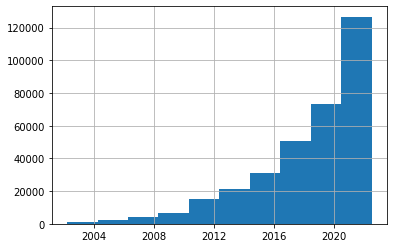

In [127]:
allocation = pd.read_csv('data/Fund_Allocation.csv', parse_dates=['Startdate', 'EndDate'])
# ? should use all kinds of report
allocation[allocation.Equity / allocation.TotalAsset > .3].EndDate.sort_values().hist()

In [134]:
allocation['proportion'] = allocation.Equity / allocation.TotalAsset

In [139]:
allocation[allocation.MasterFundCode == 1][allocation[allocation.MasterFundCode == 1].EndDate < pd.to_datetime('2003-12')]

,FundID,MasterFundCode,ReportTypeID,Startdate,EndDate,CrossCode,CrossName,Equity,StockAmount,TotalAsset,proportion
0,108426,1,1,2002-01-01,2002-03-31,1,账面金额,1.051096e+09,1.051096e+09,3.254342e+09,0.322983
1,108426,1,1,2002-01-01,2002-03-31,2,占基金总资产比例,3.230000e+01,3.230000e+01,1.000000e+02,0.323000
2,108426,1,2,2002-04-01,2002-06-30,1,账面金额,1.650510e+09,1.650510e+09,3.738304e+09,0.441513
3,108426,1,2,2002-04-01,2002-06-30,2,占基金总资产比例,4.415000e+01,4.415000e+01,1.000000e+02,0.441500
4,108426,1,3,2002-07-01,2002-09-30,1,账面金额,1.975451e+09,1.975451e+09,4.269985e+09,0.462637
5,108426,1,3,2002-07-01,2002-09-30,2,占基金总资产比例,4.626000e+01,4.626000e+01,1.000000e+02,0.462600
6,108426,1,4,2002-10-01,2002-12-31,1,账面金额,1.885997e+09,1.885997e+09,3.933701e+09,0.479446
7,108426,1,4,2002-10-01,2002-12-31,2,占基金总资产比例,4.794000e+01,4.794000e+01,1.000000e+02,0.479400
8,108426,1,1,2003-01-01,2003-03-31,1,账面金额,2.103610e+09,2.103610e+09,4.130111e+09,0.509335
9,108426,1,1,2003-01-01,2003-03-31,2,占基金总资产比例,5.093000e+01,5.093000e+01,1.000000e+02,0.509300


<AxesSubplot:>

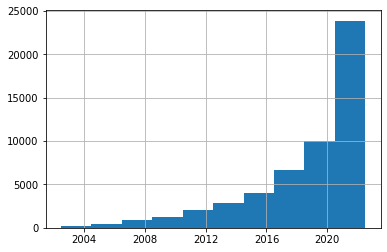

In [131]:
temp = allocation[allocation.ReportTypeID == 2]
temp[temp.Equity / temp.TotalAsset > .3].EndDate.sort_values().hist()

In [332]:
# allocation_ = allocation[np.logical_or(allocation.ReportTypeID == 5, allocation.ReportTypeID == 6)]
allocation_ = allocation.copy()
f'{round_((allocation_.Equity == allocation_.StockAmount).sum() / len(allocation_))} of lines, Equity == StockAmount'

'67.17999999999999% of lines, Equity == StockAmount'

In [333]:
not_equal = allocation[allocation.Equity != allocation.StockAmount]
temp = not_equal[['Equity', 'StockAmount']].dropna(how='all')
f'in lines where `Equity` is not equal to `StockAmount`, {round_(pd.isnull(temp).Equity.sum() / len(temp))} lines satisfies both `StockAmount != NA` and `Equity == NA`'

'in lines where `Equity` is not equal to `StockAmount`, 0.01% lines satisfies both `StockAmount != NA` and `Equity == NA`'

In [334]:
temp = allocation_.apply(lambda row: True if pd.isna(row.Equity) and pd.notna(row.TotalAsset) else False, axis=1)
f'{round_(temp.sum() / len(temp))} `Equity` is not available while `TotalAsset` is available'

'30.270000000000003% `Equity` is not available while `TotalAsset` is available'

（6）最近一次年报或半年报披露的中国市场股票持股比例超过总管理规模的 30%

In [335]:
allocation_['criteria'] = allocation_.Equity / allocation_.TotalAsset > .3
allocation_

,FundID,MasterFundCode,ReportTypeID,Startdate,EndDate,CrossCode,CrossName,Equity,StockAmount,TotalAsset,criteria
0,108426,1,1,2002-01-01,2002-03-31,1,账面金额,1.051096e+09,1.051096e+09,3.254342e+09,True
1,108426,1,1,2002-01-01,2002-03-31,2,占基金总资产比例,3.230000e+01,3.230000e+01,1.000000e+02,True
2,108426,1,2,2002-04-01,2002-06-30,1,账面金额,1.650510e+09,1.650510e+09,3.738304e+09,True
3,108426,1,2,2002-04-01,2002-06-30,2,占基金总资产比例,4.415000e+01,4.415000e+01,1.000000e+02,True
4,108426,1,3,2002-07-01,2002-09-30,1,账面金额,1.975451e+09,1.975451e+09,4.269985e+09,True
...,...,...,...,...,...,...,...,...,...,...,...
646977,10496016,980003,1,2022-01-01,2022-03-31,2,占基金总资产比例,NaN,NaN,1.000000e+02,False
646978,10496016,980003,2,2022-04-01,2022-06-30,1,账面金额,NaN,NaN,3.945168e+09,False
646979,10496016,980003,2,2022-04-01,2022-06-30,2,占基金总资产比例,NaN,NaN,1.000000e+02,False
646980,10496016,980003,5,2022-01-01,2022-06-30,1,账面金额,NaN,NaN,3.945168e+09,False


In [336]:
# merge CrossCode
def func(temp):
    if temp.criteria.any():
        return temp[temp.criteria].iloc[0]

allocation__ = allocation_.groupby(['MasterFundCode', 'EndDate']).apply(func)

In [337]:
allocation__.dropna(how='all').drop(['MasterFundCode', 'EndDate'], axis=1)

FundID  ReportTypeID  Startdate  CrossCode  \
MasterFundCode EndDate                                                      
1              2002-03-31    108426.0           1.0 2002-01-01        1.0   
               2002-06-30    108426.0           2.0 2002-04-01        1.0   
               2002-09-30    108426.0           3.0 2002-07-01        1.0   
               2002-12-31    108426.0           4.0 2002-10-01        1.0   
               2003-03-31    108426.0           1.0 2003-01-01        1.0   
...                               ...           ...        ...        ...   
970101         2022-03-31  10574039.0           1.0 2022-01-01        1.0   
               2022-06-30  10574039.0           2.0 2022-04-01        1.0   
970113         2022-03-31  10574516.0           1.0 2022-01-01        1.0   
               2022-06-30  10574516.0           2.0 2022-04-01        1.0   
970120         2022-06-30  10578152.0           2.0 2022-04-01        1.0   

                          CrossName        Equity   StockAmount    TotalAsset  \
MasterFundCode EndDate                                                          
1              2002-03-31      账面金额  1.051096e+09  1.051096e+09  3.254342e+09   
               2002-06-30      账面金额  1.650510e+09  1.650510e+09  3.738304e+09   
               2002-09-30      账面金额  1.975451e+09  1.975451e+09  4.269985e+09   
               2002-12-31      账面金额  1.885997e+09  1.885997e+09  3.933701e+09   
               2003-03-31      账面金额  2.103610e+09  2.103610e+09  4.130111e+09   
...                             ...           ...           ...           ...   
970101         2022-03-31      账面金额  3.489100e+07  3.489100e+07  4.877115e+07   
               2022-06-30      账面金额  5.069073e+07  5.069073e+07  5.736842e+07   
970113         2022-03-31      账面金额  5.851077e+07  5.851077e+07  7.921394e+07   
               2022-06-30      账面金额  7.445751e+07  7.445751e+07  8.415443e+07   
970120         2022-06-30      账面金额  1.884672e+07  1.884672e+07  6.000083e+07   

                          criteria  
MasterFundCode EndDate              
1              2002-03-31     True  
               2002-06-30     True  
               2002-09-30     True  
               2002-12-31     True  
               2003-03-31     True  
...                            ...  
970101         2022-03-31     True  
               2022-06-30     True  
970113         2022-03-31     True  
               2022-06-30     True  
970120         2022-06-30     True  

[97073 rows x 9 columns]

In [338]:
main_data_ = pd.merge(main_data, allocation__.dropna(how='all').drop(['MasterFundCode', 'EndDate'], axis=1), on=['MasterFundCode', 'EndDate'])\
    .set_index(['Symbol', 'EndDate'])[['InceptionDate_y', 'MasterFundCode', 'Category']]

<AxesSubplot:xlabel='EndDate'>

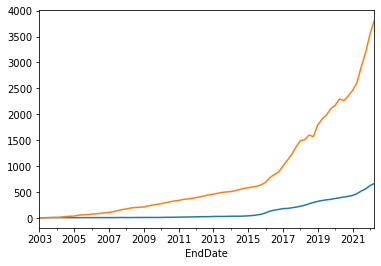

In [344]:
main_data_.groupby(level=1).apply(lambda x: (x.Category == '股票型基金').sum()).plot()
main_data_.groupby(level=1).apply(lambda x: (x.Category == '混合型基金').sum()).plot()

In [345]:
mkt_month['TradingDate'] = mkt_month.TradingDate + pd.offsets.MonthEnd(0)
mkt_month['EndDate'] = mkt_month['TradingDate']
main_data__ = pd.merge(main_data_, mkt_month, on=['Symbol', 'EndDate'])

<AxesSubplot:xlabel='EndDate'>

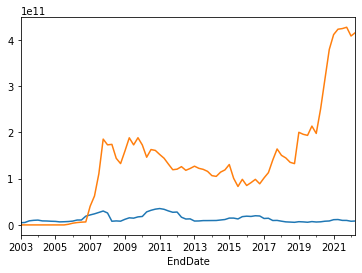

In [346]:
main_data__.groupby('EndDate').apply(lambda x: x[x.Category == '股票型基金'].MarketValue.sum()).plot()
main_data__.groupby('EndDate').apply(lambda x: x[x.Category == '混合型基金'].MarketValue.sum()).plot()

**erratum**

`MasterFundCode`

In [201]:
temp_info = pd.merge(allocation_, maininfo__, how='inner', on='MasterFundCode')
f'{round_(1 - len(temp_info) / len(maininfo__))} MasterFundCode error'

'-2227.75% MasterFundCode error'

In [114]:
filter_6 = (temp_info.Equity / temp_info.TotalAsset > .3)
main_data = temp_info[filter_6]
print(f'filter 6: {len(temp_info)} to {len(main_data)}, {round_(1 - len(main_data) / len(temp_info))} symbols dropped')

filter 6: 7199 to 5239, 27.229999999999997% symbols dropped


In [112]:
main_data = main_data.sort_index()[['MasterFundCode', 'FullName', 'Symbol']]
main_data

,MasterFundCode,FullName,Symbol
0,6,西部利得量化成长混合型发起式证券投资基金,6
1,6,西部利得量化成长混合型发起式证券投资基金,11228
2,11,华夏大盘精选证券投资基金,11
3,11,华夏大盘精选证券投资基金,12628
4,17,财通可持续发展主题混合型证券投资基金,17
...,...,...,...
7194,970043,东吴裕盈一年持有期灵活配置混合型集合资产管理计划,970045
7195,970048,东海证券海睿致远灵活配置混合型集合资产管理计划,970048
7196,970068,兴证资管金麒麟消费升级混合型集合资产管理计划,970067
7197,970068,兴证资管金麒麟消费升级混合型集合资产管理计划,970068


## II. Market Statistic

#### Fund_NAV_Month

基金表现 — 基金月净值文件

In [135]:
nav_month_ = nav_month.pivot(index='TradingMonth', columns='Symbol', values='NAV')
nav_month_

Symbol,1,3,4,5,6,7,8,9,10,11,...,970177,970178,970180,970182,970184,970185,970187,970191,970193,980003
TradingMonth,,,,,,,,,,,,,,,,,,,,,
2002-01,1.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02,1.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03,1.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04,1.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05,1.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,0.936,0.807,0.800,1.0272,1.7115,NaN,1.5681,0.0,0.0,15.588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5306
2022-05,0.982,0.828,0.820,1.0336,1.8559,NaN,1.6798,0.0,0.0,16.868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5365
2022-06,1.073,0.880,0.871,1.0306,2.0785,NaN,1.8062,0.0,0.0,18.869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5393


In [29]:
f'{round_((nav_month_ == 0).sum().sum() / (nav_month_.shape[0] * nav_month_.shape[1]))} values is 0'

'1.5599999999999998% values is 0'

In [136]:
nav_month__ = nav_month_.replace(0, np.nan)
nav_month__

Symbol,1,3,4,5,6,7,8,9,10,11,...,970177,970178,970180,970182,970184,970185,970187,970191,970193,980003
TradingMonth,,,,,,,,,,,,,,,,,,,,,
2002-01,1.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02,1.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03,1.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04,1.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05,1.027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,0.936,0.807,0.800,1.0272,1.7115,NaN,1.5681,NaN,NaN,15.588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5306
2022-05,0.982,0.828,0.820,1.0336,1.8559,NaN,1.6798,NaN,NaN,16.868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5365
2022-06,1.073,0.880,0.871,1.0306,2.0785,NaN,1.8062,NaN,NaN,18.869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5393


erratum

base research `Symbol` on `unitclassinfo`

In [137]:
len(np.intersect1d(nav_month__.columns, unitclassinfo_.index)), len(nav_month__.columns), len(unitclassinfo_.index)

(14947, 18917, 19155)

In [138]:
np.setdiff1d(nav_month__.columns, unitclassinfo_.index)

array([   927,   1710,   1715, ..., 970191, 970193, 980003], dtype=int64)

In [139]:
np.setdiff1d(unitclassinfo_.index, nav_month__.columns)

array([    0,     2,    12, ..., 19257, 19258, 19259], dtype=int64)

#### Fund_Resolution, Fund_FundDividend

收益分配与拆分 — 基金分配文件

收益分配与拆分 — 基金拆分信息文件


In [140]:
f'{round_(pd.isnull(resolution.SplitRatio).sum() / len(resolution))} `SplitRatio` is not available'

'0.13% `SplitRatio` is not available'

In [141]:
f'{round_(pd.isnull(fund_dividend.PrimaryExDividendDate).sum() / len(fund_dividend))} `PrimaryExDividendDate` is not available'

'1.28% `PrimaryExDividendDate` is not available'

In [142]:
f'{round_(pd.isnull(fund_dividend.SecondaryExDividendDate).sum() / len(fund_dividend))} `SecondaryExDividendDate` is not available'

'92.64% `SecondaryExDividendDate` is not available'

In [143]:
temp = fund_dividend.apply(lambda row: True if pd.notnull(row.SecondaryExDividendDate) and pd.isna(row.PrimaryExDividendDate) else False, axis=1).sum() / len(fund_dividend)
f'when `PrimaryExDividendDate` is not available, there stands {round_(temp)} chance `SecondaryExDividendDate` is available'


'when `PrimaryExDividendDate` is not available, there stands 1.28% chance `SecondaryExDividendDate` is available'

In [144]:
ExDividendMonth = fund_dividend.PrimaryExDividendDate.dt.strftime('%Y-%m').copy()
ExDividendMonth.name = 'ExDividendMonth'
ExDividendMonth[ExDividendMonth.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendMonth.isnull()].dt.strftime('%Y-%m').copy()
fund_dividend['ExDividendMonth'] = ExDividendMonth


In [145]:
temp = fund_dividend.groupby(['Symbol', 'ExDividendMonth']).apply(lambda one_month: len(one_month))
f'{round_(len(temp[temp != 1]) / len(temp))} funds have multiple dividend payouts in one month'

'1.28% funds have multiple dividend payouts in one month'

In [146]:
split = resolution.set_index(['Symbol', resolution.DeclareDate.dt.strftime('%Y-%m')]).copy().SplitRatio
f'{round_(len(split[split.index.duplicated(keep=False)]) / len(split))} funds have multiple divisions in one month'

'1.0699999999999998% funds have multiple divisions in one month'

#### Fund_FeesChange

基金概况 — 费率变动文件

erratum

In [147]:
duplicated_fees = fees[fees.NameOfFee == '管理费率'][fees[fees.NameOfFee == '管理费率'][['Symbol', 'DeclareDate']].duplicated(keep=False)]

In [148]:
f'{round_(len(duplicated_fees) / len(fees))} data are duplicated as below'

'0.01% data are duplicated as below'

In [149]:
duplicated_fees.head(10).style.apply(\
    lambda x : ['background-color: yellow' if x.name in [86751, 86763, 86775, 87636, 98290] else '' for _ in x], axis=1)

,Symbol,DeclareDate,TypeOfFee,NameOfFee,ProportionOfFee
86751,000613,2015-01-16 00:00:00,B1804,管理费率,0.5
86753,000613,2015-01-16 00:00:00,B1804,管理费率,0.8
86763,000613,2015-07-20 00:00:00,B1804,管理费率,0.5
86765,000613,2015-07-20 00:00:00,B1804,管理费率,0.8
86775,000613,2016-01-18 00:00:00,B1804,管理费率,0.5
86777,000613,2016-01-18 00:00:00,B1804,管理费率,0.8
87636,000619,2016-01-15 00:00:00,B1804,管理费率,2.5
87648,000619,2016-01-15 00:00:00,B1804,管理费率,1.5
98290,000708,2016-03-08 00:00:00,B1804,管理费率,0.7
98302,000708,2016-03-08 00:00:00,B1804,管理费率,1.5


![](attachment/fees.png)

In [151]:
fees_ = fees[fees.NameOfFee == '管理费率'][~ fees[fees.NameOfFee == '管理费率'][['Symbol', 'DeclareDate']].duplicated()]
fees_['Symbol'] = fees_.Symbol.astype(int)
fees_['ProportionOfFee'] = fees_.ProportionOfFee.astype(float)

In [152]:
fees_.pivot(index='DeclareDate', columns='Symbol', values='ProportionOfFee')

Symbol,1,3,4,5,6,7,8,9,10,11,...,970180,970182,970184,970185,970187,970191,970193,970194,970195,980003
DeclareDate,,,,,,,,,,,,,,,,,,,,,
2003-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Fund_MKT_QuotationMonth

基金行情 — 基金月行情信息表

In [153]:
mkt_month_ = mkt_month.pivot(index='TradingDate', columns='Symbol', values='MarketValue').resample('1M').last()
mkt_month_

Symbol,150001,150002,150003,150006,150007,150008,150009,150010,150011,150012,...,588180,588260,588280,588300,588310,588330,588360,588380,588390,588400
TradingDate,,,,,,,,,,,,,,,,,,,,,
2002-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.415023e+09,612517158.0,169435476.0,1.537111e+09,69715874.31,1.108638e+09,529903033.8,1.760455e+09,3.396345e+08,1.741277e+09
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.593988e+09,628683300.0,171393768.0,1.628788e+09,68074061.73,1.187620e+09,568109623.2,1.945783e+09,3.501681e+08,1.931127e+09
2022-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.573924e+09,594554778.0,169272558.0,1.573103e+09,65878124.25,1.144777e+09,547707896.4,1.870945e+09,3.377768e+08,1.869998e+09


## I. Filter data

（1）基金类别必须为“股票型基金”或“混合型基金”；

（2）非 ETF 类基金；

（3）非 QDII 类基金；

（4）主动管理标识为 1 或者为空；

### erratum

In [3]:
%%time

# (1)
# Category [基金类别] - 股票型基金；债券型基金；货币型基金；混合型基金；FOF；股指期货型基金；其他
# TODO: why duplicated?
# ? duplicated MasterFundCode with different actual name
# check with `maininfo.loc[condition_1[condition_1.duplicated(keep=False)].index]`
condition_1 = maininfo[np.logical_or(maininfo.Category == '股票型基金', maininfo.Category == '混合型基金')].MasterFundCode.unique()

# (2)
# IsETF [是否ETF] - 1=是；2=否
condition_2 = maininfo[maininfo.IsETF == 2].MasterFundCode.unique()

# (3)
# IsQDII [是否QDII] - 1=是；2=否
condition_3 = maininfo[maininfo.IsQDII == 2].MasterFundCode.unique()

# (4)
# IsActiveOrPassive [主动标识] - 1=主动；2=被动
condition_4 = maininfo[maininfo.IsActiveOrPassive != 2].MasterFundCode.unique()

# (5)
# TODO: `上市日期` or `发行日期`
# TODO: 3 steps

# * `上市日期` 超过1年
# note, `MasterFundCode` in `unitclassinfo` is `Symbol` column
condition_5_ = unitclassinfo[(pd.Timestamp.now() - unitclassinfo.ListingDate).apply(lambda timedelta: timedelta.days>365)].Symbol.unique()
# len(condition_5_) -> 703

# * `发行日期` 超过1年
condition_5__ = maininfo[(pd.Timestamp.now() - maininfo.InceptionDate).apply(lambda timedelta: timedelta.days>365)].MasterFundCode.unique()
# len(condition_5__) -> 2782

# * `上市日期` 或 `发行日期` 超过1年
condition_5 = np.array(list(set(np.concatenate([condition_5_, condition_5__]))))
# len(condition_5) -> 3122


# (6)
# ! CSMAR do not have `mainland && stock in portfolio proportion` data, we have to calculate it manually
# ! the most similar data is `areaclass`, but only cover 170 funds
# areaclass = pd.read_csv('data/FUND_AREACLASS.csv')
# print(len(areaclass.groupby('MasterFundCode').apply(lambda x: 0)))

# ReportTypeID [定期报告类别编码] - 1－第一季度；2－第二季度；3－第三季度；4－第四季度；5－半年度；6－年度；7－其他周期
# Startdate [开始日期] - 
# EndDate [截止日期] - 
# InvestmentType [投资类型分类] - 1=积极投资； 2=指数投资；3=综合；4=新股型。
# Rank [排名]
# Symbol [股票代码]
# StockName [股票名称]
# Proportion [占净值比例(%)]

# TODO: Symbol v.s. MasterFundCode
# TODO: how many mutual funds total?
# TODO: why `len(condition_6)` so small?
# filter the last report period
last_report_period_portfolio_stock = portfolio_stock.groupby('MasterFundCode')\
    .apply(lambda one_code: one_code[one_code.EndDate == one_code.EndDate.iloc[-1]])\
        .set_index('MasterFundCode')

portfolio_stock_ = last_report_period_portfolio_stock


# filter China mainland stock
mainland_code = '6\d{5}|9\d{5}|0\d{5}|2\d{5}|3\d{5}|8\d{5}|4\d{5}'
last_report_period_portfolio_mainland_stock = portfolio_stock_[\
    portfolio_stock_.Symbol.apply(lambda code: True if re.match(mainland_code, code) else False)]

portfolio_stock__ = last_report_period_portfolio_mainland_stock

# ! 576 annual report only
# code_series = portfolio_stock__.groupby(level=0)\
#     .apply(lambda one_code: True if one_code[one_code.ReportTypeID == 6].Proportion.sum() > .3 else False)

# sum annual report proportion and compare with 30%
code_series = portfolio_stock__.groupby(level=0)\
    .apply(lambda one_code: True if one_code[\
        np.logical_or(one_code.ReportTypeID == 6, one_code.ReportTypeID == 5)]\
            .Proportion.sum() > .3 else False)

condition_6 = code_series[code_series].index.values

len(condition_1), len(condition_2), len(condition_3), len(condition_4), len(condition_5), len(condition_6)

CPU times: user 12.3 s, sys: 503 ms, total: 12.8 s
Wall time: 12.9 s


(7122, 10589, 11136, 9452, 10025, 6877)

In [4]:
fund_codes = reduce(np.intersect1d, [condition_1, condition_2, condition_3, condition_4, condition_5, condition_6])
fund_codes, len(fund_codes)

(array([     6,     11,     17, ..., 970043, 970048, 970068]), 4411)

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

In [155]:
%%time

# TODO: 872018, 872020 not in `fund_dividend` but in `fund_codes`
# maininfo[maininfo.MasterFundCode == 872020]
# fund_dividend[fund_dividend.Symbol == 872020]

# * ------------ NAV_t+Div_t start ------------

ExDividendDate = fund_dividend.PrimaryExDividendDate.dt.strftime('%Y-%m').copy()
ExDividendDate.name = 'ExDividendMonth'
ExDividendDate[ExDividendDate.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendDate.isnull()].dt.strftime('%Y-%m').copy()

# * dividend paid multiple times in one month
# check with
# `fund_dividend.groupby(['Symbol', ExDividendDate]).apply(lambda one_month: print(one_month) if len(one_month) != 1 else one_month.DividendperShare.sum())`
dividend = fund_dividend.groupby(['Symbol', ExDividendDate]).apply(lambda one_month: one_month.DividendperShare.sum())

nav = nav_month.copy().set_index(['Symbol', 'TradingMonth']).NAV
co_time = np.intersect1d(dividend.index, nav.index)

dividend_adj_nav = nav.copy()
dividend_adj_nav.loc[co_time] += dividend.loc[co_time] / 10

# * ------------ NAV_t+Div_t end ------------



# * ------------ (NAV_t+Div_t)*SF_t start ------------

split = resolution.set_index(['Symbol', resolution.DeclareDate.dt.strftime('%Y-%m')]).copy().SplitRatio

# * split multiple times in one month
# check with `split[split.index.duplicated(keep=False)]`
split = split.groupby(level=[0, 1]).apply(sum)

# ? after the end of net value record, split may happens
# check with
# np.setdiff1d(split.index, dividend_adj_nav.index)
# dividend_adj_nav.unstack(0)[162109].plot()
# dividend_adj_nav.unstack(0)[184689].plot()
# ...
split = split.drop(np.setdiff1d(split.index, dividend_adj_nav.index))

dividend_adj_nav.loc[split.index] *= split

# * ------------ (NAV_t+Div_t)*SF_t end ------------



# * ------------ R_t^{real} ------------

nav.loc[split.index] *= split

r_t_real = dividend_adj_nav.unstack(0) / nav.unstack(0).shift(1)
print(r_t_real.shape)

# specify funds we use
# ! in case: 872018, 872020 not in `fund_dividend` but in `fund_codes`
# r_t_real = r_t_real[fund_codes]

r_t_real = r_t_real[np.intersect1d(r_t_real.columns, fund_codes)]
r_t_real.index = pd.to_datetime(r_t_real.index)
print(r_t_real.shape)

# * ------------ R_t^{real} ------------

(248, 18917)


NameError: name 'fund_codes' is not defined

Additional

(7) Check

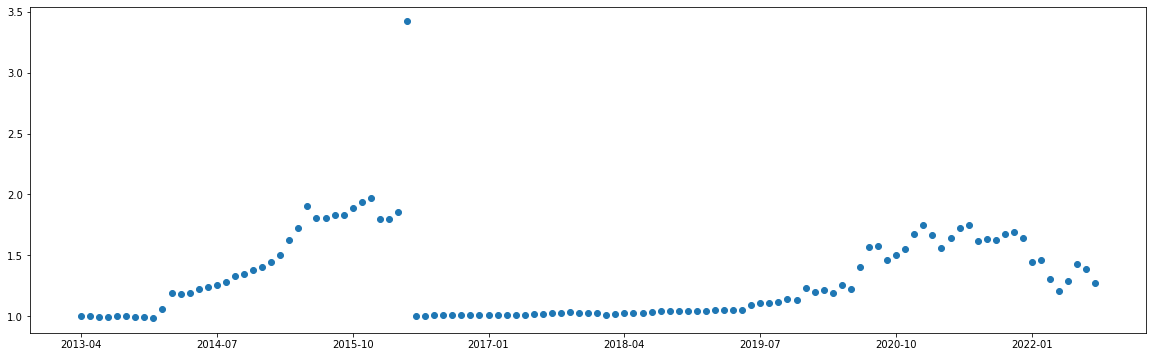

In [156]:

# TODO: why 1.4?
possible_errors = r_t_real.columns[(np.abs(r_t_real) > 1.4).any()]

plt.figure(figsize=(20,6))
this_code_nav = nav[nav.index.get_level_values(0) == possible_errors[0]]
plt.scatter(this_code_nav.index.get_level_values(1), this_code_nav.values)
plt.xticks(this_code_nav.index.get_level_values(1)[::15])
pass

In [36]:
r_t_real_ = r_t_real.drop(possible_errors, axis=1)
pass

In [37]:
stock_fund = np.intersect1d(maininfo[maininfo.Category == '股票型基金'].MasterFundCode.unique(), fund_codes)
integrated_fund = np.intersect1d(maininfo[maininfo.Category == '混合型基金'].MasterFundCode.unique(), fund_codes)

# TODO: in case use full range funds
# stock_fund = maininfo[maininfo.Category == '股票型基金'].MasterFundCode.unique()
# integrated_fund = maininfo[maininfo.Category == '混合型基金'].MasterFundCode.unique()

In [157]:
# SgnMonth [统计月份] - null
# CategoryID [基金类型编号] - 0:全部基金;1:股票型基金;2:债券型基金;3:货币型基金;4:混合型基金;5:FOF;6:商品期货型基金;7:REITs;8:其他;21:封闭式基金;22:开放式基金;31:场内基金;32:场外基金;40:ETF基金;50:LOF基金
# TotalFundNAV [基金总资产净值] - 对应类型的所有基金的总资产净值

# TODO: 不一致

stock_mkt_month = mkt_month[mkt_month.CategoryID == 1].resample('12M').mean()
mixed_mkt_month = mkt_month[mkt_month.CategoryID == 4].resample('12M').mean()
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16)
ax1.plot(stock_mkt_month.FundNum, linewidth=5, label='股票型基金总数量（折线）')
ax1.plot(mixed_mkt_month.FundNum, linewidth=5, label='混合型基金总数量（折线）')
ax1.set_yscale('log')
ax1.set_yticks([100, 1000, 10000])

ax2 = ax1.twinx()
ax2.bar(stock_mkt_month.index - pd.Timedelta('7W'), stock_mkt_month.TotalFundNAV.values, width=100 ,label='股票型基金总市值（柱状）', alpha=.8)
ax2.bar(mixed_mkt_month.index + pd.Timedelta('7W'), mixed_mkt_month.TotalFundNAV.values, width=100 ,label='混合型基金总市值（柱状）', alpha=.8)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

AttributeError: 'DataFrame' object has no attribute 'CategoryID'

Text(0.5, 1.0, '「所有」基金管理费率日平均（柱状）/季度平均（折线）')

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/pdx01/.local/lib/python3.10/site-package

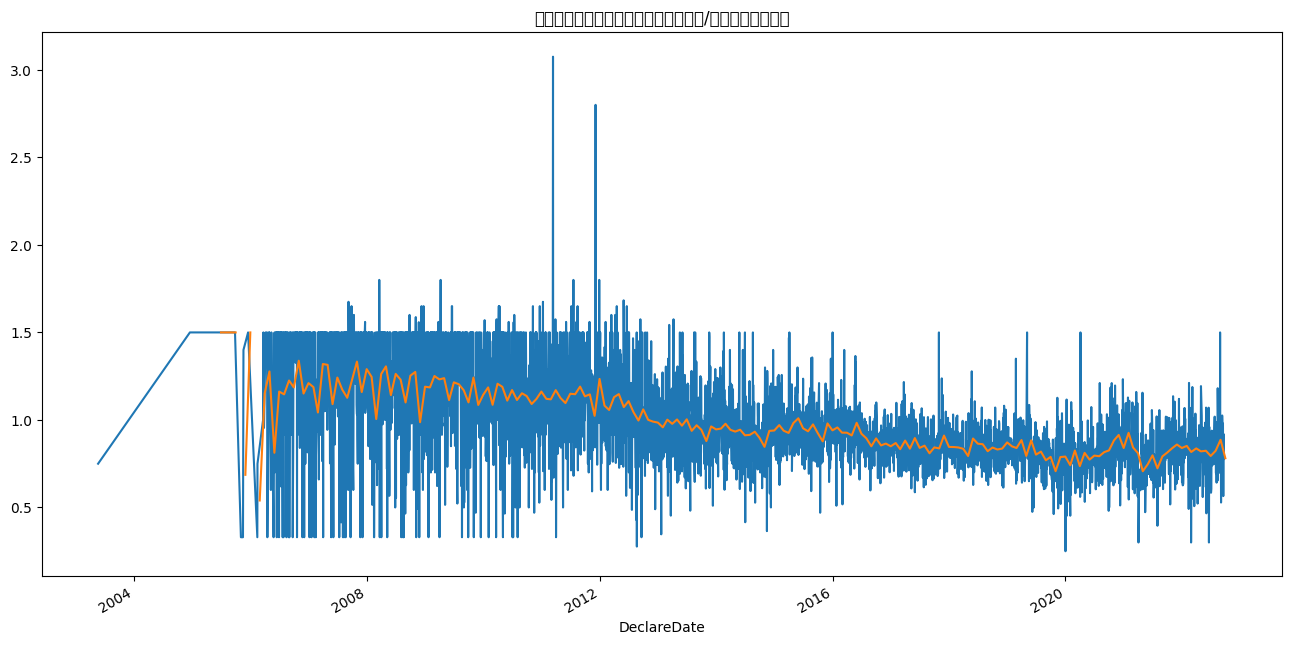

In [39]:
management_fee = fees[fees.NameOfFee == '管理费率']
# TODO: minimal subscription written to management fee
# management_fee[management_fee.ProportionOfFee.astype(float) == 1000]
management_fee_ = management_fee[management_fee.ProportionOfFee.astype(float) != 1000]

# smallest date interval
management_fee__ = management_fee_.groupby('DeclareDate').apply(lambda one_date: one_date.ProportionOfFee.astype(float).mean())
plt.figure(figsize=(16,8))
management_fee__.plot()
management_fee__.resample('1M').mean().plot()
plt.title('「所有」基金管理费率日平均（柱状）/季度平均（折线）')
# TODO: 国泰安数据不全，2006前数据缺失
# TODO: 不一致

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

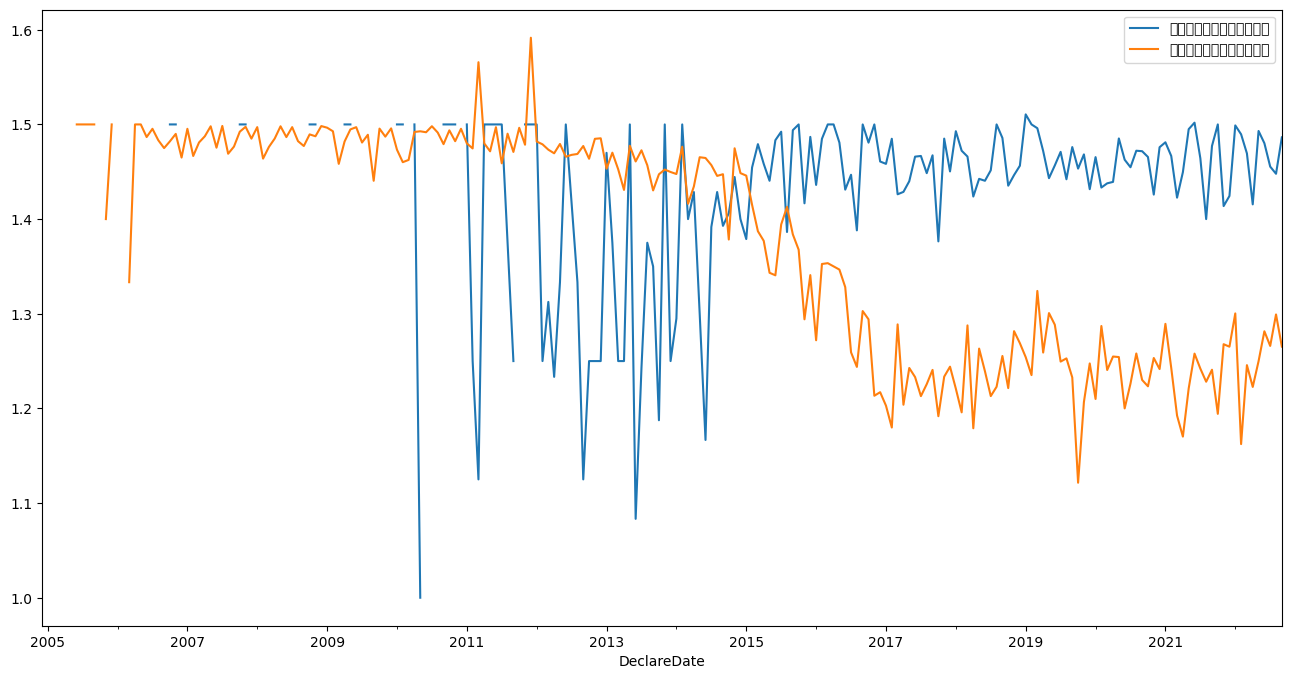

In [40]:
management_fee_stock_fund = management_fee_.groupby('Symbol').apply(\
    lambda one_fund: one_fund if float(one_fund.Symbol.unique()[0]) in stock_fund else None)
    
management_fee_integrated_fund = management_fee_.groupby('Symbol').apply(\
    lambda one_fund: one_fund if float(one_fund.Symbol.unique()[0]) in integrated_fund else None)

management_fee_stock_fund_ = management_fee_stock_fund.groupby('DeclareDate').apply(\
    lambda one_date: one_date.ProportionOfFee.astype(float).mean())
management_fee_integrated_fund_ = management_fee_integrated_fund.groupby('DeclareDate').apply(\
    lambda one_date: one_date.ProportionOfFee.astype(float).mean())

plt.figure(figsize=(16,8))
management_fee_stock_fund_.resample('1M').mean().plot(label='股票型基金季度平均管理费')
management_fee_integrated_fund_.resample('1M').mean().plot(label='混合型基金季度平均管理费')
plt.legend()

## II.Select

月末等权重买入一种分类中所有基金

持有一个月，按月滚动调整

**?等金额权重/等份额权重**

In [56]:

# ! S_DQ_ADJCLOSE
stock_avg_change = full.pivot(index='TRADE_DT', columns='S_INFO_WINDCODE', values='S_DQ_CLOSE').pct_change()\
    .apply(lambda date: date.sum()/pd.notnull(date).sum() if date.sum() != 0 else None, axis=1)\
        .loc['2002-1-1':'2022-9-22']

stock_return = (stock_avg_change + 1).cumprod()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

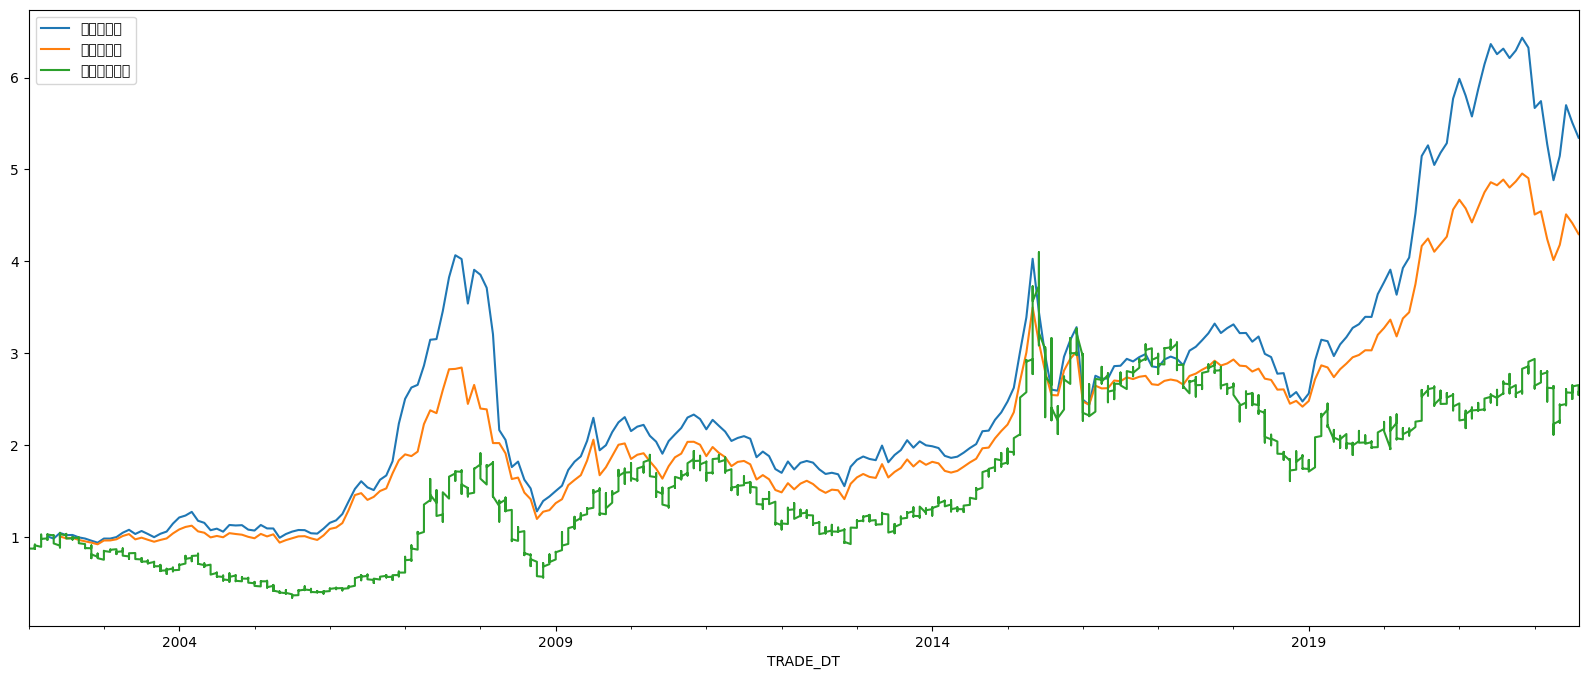

In [57]:
# 等份额权重
# remove all null month
# TODO, probable cause: funds listed before 2022-04 did not meet other requirements

plt.figure(figsize=(20,8))
stock_r_t = r_t_real_[np.intersect1d(stock_fund, r_t_real_.columns)]
stock_r_t_ = stock_r_t[~ pd.isnull(stock_r_t).all(axis=1)]
stock_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='股票型基金')
mixed_r_t = r_t_real_[np.intersect1d(integrated_fund, r_t_real_.columns)]
mixed_r_t_ = mixed_r_t[~ pd.isnull(mixed_r_t).all(axis=1)]
mixed_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='混合型基金')
stock_return.plot(label='股票市场组合')
plt.legend()